# GIN

**Without attention**

We are inspired by the following blog: https://towardsdatascience.com/how-to-design-the-most-powerful-graph-neural-network-3d18b07a6e66

In [20]:
import torch
import numpy as np
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt
import pandas as pd

We train GIN on the following datasets:
* Proteins,
* Mutag,
* PTC_MM,
* Enzymes,
* DD,
* NCI1.

In [73]:
dataset = TUDataset(root='.', name='NCI1').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: NCI1(4110)
-------------------
Number of graphs: 4110
Number of nodes: 28
Number of features: 37
Number of classes: 2


We use mini-batching as it's very effective.

In [74]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('/nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('/nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('/nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 3288 graphs
Validation set = 411 graphs
Test set       = 411 graphs
/nTrain loader:
 - Subgraph 0: DataBatch(edge_index=[2, 3804], x=[1752, 37], y=[64], batch=[1752], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 4166], x=[1922, 37], y=[64], batch=[1922], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 4392], x=[2038, 37], y=[64], batch=[2038], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 4258], x=[1971, 37], y=[64], batch=[1971], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 3894], x=[1817, 37], y=[64], batch=[1817], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 4692], x=[2153, 37], y=[64], batch=[2153], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 3832], x=[1793, 37], y=[64], batch=[1793], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 4226], x=[1944, 37], y=[64], batch=[1944], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 4028], x=[1865, 37], y=[64], batch=[1865], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 3980], x=[1847, 37], y

We build GIN architecture as it's introduced in the paper "How powerful are Graph Neural Networks?".

In [75]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv4 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv5 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

gin = GIN(dim_h=32)

Training

In [76]:
loss_list = []

def train(model, loader, epochs=300, labels_indexed_from_0 = True):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for data in loader:
        if not labels_indexed_from_0:
          data.y = data.y - 1
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.long())
        total_loss += loss / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y.long()) / len(loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                f'| Train Acc: {acc*100:>5.2f}% '
                f'| Val Loss: {val_loss:.2f} '
                f'| Val Acc: {val_acc*100:.2f}%')
            
      test_loss, test_acc = test(model, test_loader)
      loss_list.append(test_loss)
      
      print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

def test(model, loader, labels_indexed_from_0 = True):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
      if not labels_indexed_from_0:
        data.y = data.y-1
      _, out = model(data.x, data.edge_index, data.batch)
      loss += criterion(out, data.y.long()) / len(loader)
      
      acc += accuracy(out.argmax(dim=1), data.y.long()) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gin = train(gin, train_loader)

Epoch   0 | Train Loss: 0.77 | Train Acc: 55.52% | Val Loss: 0.66 | Val Acc: 60.78%
Test Loss: 0.65 | Test Acc: 63.32%
Test Loss: 0.64 | Test Acc: 61.67%
Test Loss: 0.64 | Test Acc: 62.48%
Test Loss: 0.66 | Test Acc: 59.72%
Test Loss: 0.64 | Test Acc: 61.67%
Test Loss: 0.63 | Test Acc: 61.67%
Test Loss: 0.63 | Test Acc: 62.79%
Test Loss: 0.63 | Test Acc: 63.01%
Test Loss: 0.63 | Test Acc: 62.73%
Test Loss: 0.66 | Test Acc: 59.72%
Epoch  10 | Train Loss: 0.65 | Train Acc: 60.61% | Val Loss: 0.65 | Val Acc: 60.31%
Test Loss: 0.63 | Test Acc: 61.90%
Test Loss: 0.64 | Test Acc: 61.14%
Test Loss: 0.63 | Test Acc: 63.01%
Test Loss: 0.63 | Test Acc: 61.67%
Test Loss: 0.63 | Test Acc: 61.90%
Test Loss: 0.64 | Test Acc: 61.37%
Test Loss: 0.63 | Test Acc: 63.01%
Test Loss: 0.64 | Test Acc: 61.67%
Test Loss: 0.63 | Test Acc: 61.67%
Test Loss: 0.63 | Test Acc: 61.90%
Epoch  20 | Train Loss: 0.64 | Train Acc: 63.33% | Val Loss: 0.63 | Val Acc: 61.31%
Test Loss: 0.63 | Test Acc: 61.67%
Test Loss: 0.

We save the model.

In [33]:
torch.save(gin.state_dict(), "C:/Users/patry/OneDrive/Pulpit/Studia_II_stopien/Uczenie_maszynowe/Projekt/models/nci1.h5")

We save values of the loss to txt file.

In [77]:
loss_list = [float(x) for x in loss_list]

np.savetxt("C:/Users/patry/OneDrive/Pulpit/Studia_II_stopien/Uczenie_maszynowe/Projekt/Loss_values/NCI1_wo_attention.txt", loss_list)

We plot values of the averaged loss function.

In [78]:
def moving_average(x: list, window_size = 10) -> list:
    
    return pd.Series(x).rolling(window=window_size).mean().iloc[window_size-1:].values

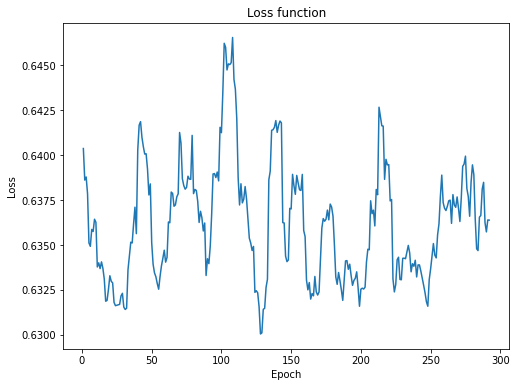

In [79]:
y = moving_average(loss_list)
x = [i for i in range(1, len(y) + 1)]

plt.figure(figsize = (8,6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function")
plt.plot(x, y)
plt.show()